In [1]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit import transpile

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import copy
import math

In [2]:
def grayvalue_to_angle(value):
    return value * pi/2

def grayscale_to_angles(image_mat):
    for i in range(len(image_mat)):
        for j in range(len(image_mat)):
            image_mat[i][j] = grayvalue_to_angle(image_mat[i][j])
    
    return image_mat

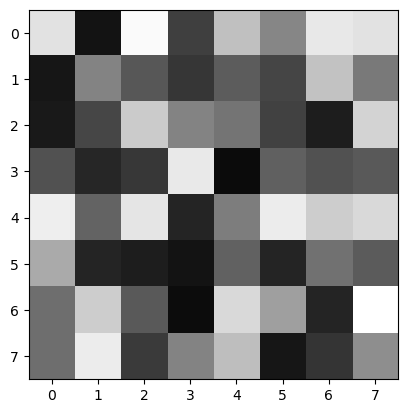

In [3]:
image = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0]
]).astype(float)

np.random.seed(321)
rand_image = np.random.rand(8,8)
image = rand_image

max_intensity = max([val for row in image for val in row])

_ = plt.imshow(image, cmap='gray', vmin=0, vmax=1)

In [5]:
intensities = []

for i in range(len(image)):
    for j in range(len(image[i])):
        intensities.append((image[i][j], i, j))

intensities = sorted(intensities)

avg_intensities = [0 for _ in range(len(intensities))]
positions_map = []

i = 0
for j in range(4):
    for i in range(4):
        i*=2
        i+= 16*j
        avg_intensities[i:i+2] = np.ones(2)*(intensities[i][0] + intensities[i+1][0] + intensities[i+2][0] + intensities[i+3][0]) / 4.0
        avg_intensities[i+8:i+10] = np.ones(2)*(intensities[i][0] + intensities[i+1][0] + intensities[i+2][0] + intensities[i+3][0]) / 4.0
        positions_map.append([intensities[i][1]*len(image)+intensities[i][2], intensities[i+1][1]*len(image)+intensities[i+1][2], intensities[i+8][1]*len(image)+intensities[i+8][2], intensities[i+9][1]*len(image)+intensities[i+9][2]])

# print(intensities)

[[28, 51, 42, 54], [43, 1, 41, 35], [61, 8, 45, 25], [16, 22, 62, 11], [26, 58, 10, 31], [3, 21, 50, 47], [13, 17, 12, 29], [24, 30, 44, 33], [56, 48, 9, 5], [46, 20, 63, 53], [15, 36, 40, 60], [19, 59, 4, 14], [18, 49, 34, 6], [38, 23, 27, 57], [39, 52, 37, 32], [7, 0, 2, 55]]


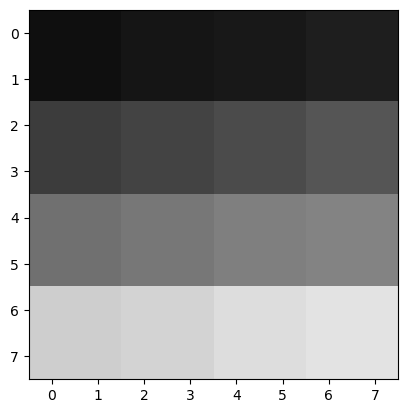

In [6]:
image_8 = np.array(avg_intensities).reshape((8, 8))
_ = plt.imshow(image_8, cmap='gray', vmin=0, vmax=1)
print(positions_map)

In [7]:
intensities = [i for image_row in image_8 for i in image_row]
sqrt_intensities = [np.sqrt(i) for i in avg_intensities]
scaled_intensities = [i*(1/np.sqrt(sum(avg_intensities))) for i in sqrt_intensities]

In [8]:
qc = QuantumCircuit(6)

# initialization to match amplitudes
qc.initialize(scaled_intensities)
qc.measure_all()

# qc.draw('mpl')

In [9]:
transpiled_circuit = transpile(qc, basis_gates=['cx', 'id', 'rz', 'sx', 'x'], optimization_level=3)
print('Circuit Depth:', transpiled_circuit.depth())
#. transpiled_circuit.draw('mpl')


Circuit Depth: 63


{'001101': 1455, '011010': 3814, '000111': 1730, '001010': 1269, '010010': 3985, '010100': 4519, '000010': 1223, '000011': 1236, '011111': 5087, '101010': 7018, '000110': 1821, '001110': 1844, '011000': 3592, '111110': 13401, '100000': 6536, '010110': 4989, '010001': 3526, '010111': 5074, '000000': 908, '011101': 4341, '110001': 12064, '000101': 1455, '010101': 4446, '101111': 7861, '011100': 4342, '101011': 6959, '110010': 12504, '100100': 7411, '001000': 898, '111010': 12425, '111100': 12937, '010000': 3646, '100110': 7848, '000100': 1505, '100111': 7803, '101100': 7595, '101001': 6715, '001011': 1237, '011011': 4062, '001001': 907, '110000': 12188, '110011': 12559, '101101': 7684, '110101': 12954, '001111': 1753, '110110': 13397, '100011': 6999, '011110': 4904, '111011': 12491, '000001': 885, '100101': 7467, '100010': 7101, '010011': 3949, '110111': 13420, '011001': 3552, '111001': 12154, '100001': 6661, '110100': 13210, '101110': 7826, '111101': 12721, '111000': 12169, '111111': 13

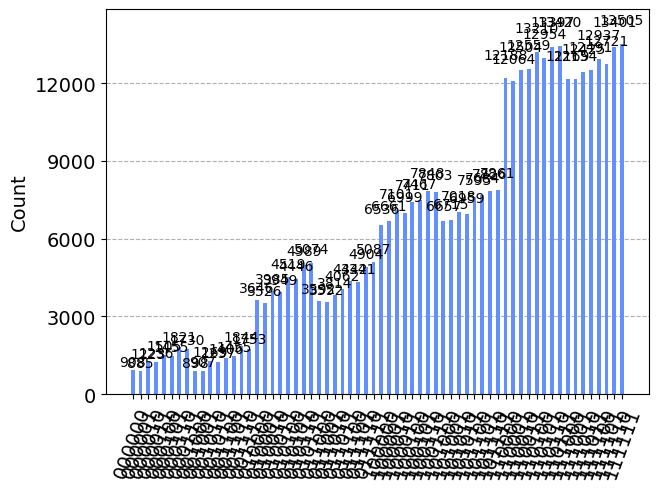

In [10]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
result = aer_sim.run(t_qc, shots=50*8192).result()
counts = result.get_counts(qc)

print(counts)
plot_histogram(counts)

In [11]:
# Image reconstruction
highest_count = max(counts.values())
rec_image = [[0 for _ in range(8)] for _ in range(8)]

for k in counts.keys():
    q1 = int(k[:3], 2)
    q2 = int(k[3:], 2)
    
    rec_image[q1][q2] = (counts[k]/highest_count)*max_intensity

0.8933778578669401
0.9970798109936965


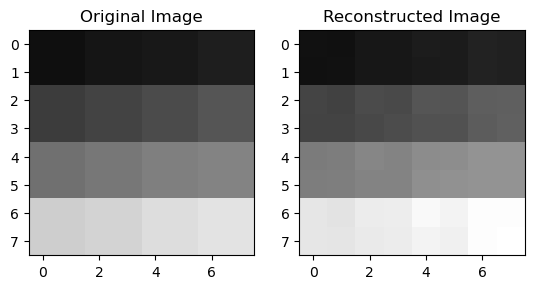

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

_ = ax1.imshow(image_8, cmap='gray', vmin=0, vmax=1)
_ = ax1.set_title('Original Image')

_ = ax2.imshow(rec_image, cmap='gray', vmin=0, vmax=1)
_ = ax2.set_title('Reconstructed Image')

print(np.max(image_8))
print(np.max(rec_image))

In [13]:
image_diff = image_8 - rec_image
squared_diff = 0
for i in range(len(image_diff)):
    for j in range(len(image_diff[i])):
        squared_diff += image_diff[i][j]**2

print('Squared error:', squared_diff)

Squared error: 0.2036828128989908


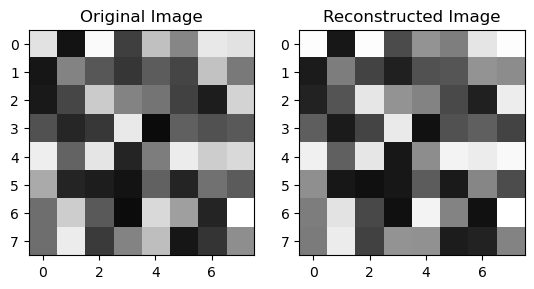

In [16]:
# print(np.max(rec_image))
final_rec_image = [[0 for _ in range(len(image))] for _ in range(len(image))]
vec_intensities = [val for row in rec_image for val in row]
# print(np.max(vec_intensities))
for i in range(math.floor(len(vec_intensities)/4)):
    for k in range(4):
        #print(k,i)
        pos_x = math.floor(positions_map[i][k]/len(image))
        pos_y = positions_map[i][k]%len(image)
        
        if i % 8 >= 4:
            z = 8
        else:
            z = 0
        
        if k <2:
            vec_index = 2*i + k
        else:
            vec_index = 2*i + 8 + k - 2
            
        index_x = 2 * (i//4) + k//2 + 2*(i // 16)
        index_y = (2*i) % 8 + k % 2
        final_rec_image[pos_x][pos_y] = rec_image[index_x][index_y]
        
        # print(index_x,index_y)
        #rescale to max_intensity
        #final_rec_image[pos_x][pos_y] *= max_intensity / np.max(vec_intensities)
# print(np.max(rec_image))        
fig, (ax1, ax2) = plt.subplots(ncols=2)

_ = ax1.imshow(image, cmap='gray', vmin=0, vmax=1)
_ = ax1.set_title('Original Image')

_ = ax2.imshow(final_rec_image, cmap='gray', vmin=0, vmax=1)
_ = ax2.set_title('Reconstructed Image')

# print(np.max(image))
# print(np.max(final_rec_image))

In [17]:
image_diff = image - final_rec_image
squared_diff = 0
for i in range(len(image_diff)):
    for j in range(len(image_diff[i])):
        squared_diff += image_diff[i][j]**2

print('Squared error:', squared_diff)

Squared error: 0.32845822499874716
